### Recreate the findings from `Cultural influences on word meanings revealed through large-scale semantic alignment`

Article can be found [here](https://www.nature.com/articles/s41562-020-0924-8)

What we want: 
- compare how "close" a synthetic language is to real english and real source language. 

What we have:
- across different settings (real, synthetic)
    - across different languages 
        - the sim approach developed in paper above. 


In [7]:
import pandas as pd 
import matplotlib.pyplot as plt


def filter_df(df):
    df = df[df['tr_src_word'] != 'tr_tar_word']
    df.dropna(subset=['sim', 'tr_sim'], inplace=True)
    df = df[(df['sim'] > -1) & (df['tr_sim'] > -1)]
    df = df[(df['sim'] < 1) & (df['tr_sim'] < 1)]
    return df


In [ ]:
data_source = 'concreteness' # concreteness, NorthErualex_concepts
data_dir = f'../data/{data_source}/similarity/'
settings = ['synthetic_synthetic', 'real_real', 'synthetic_real']
langs = ['en','fr','de','ja', 'ru','et','hi']
model_name = 'Meta-Llama-3-1-70B-Instruct-htzs' # 'Meta-Llama-3-1-8B-Instruct-nwxcg', 'Meta-Llama-3-1-70B-Instruct-htzs'
pearsons = []


for setting in settings:
    for lang1 in langs:
        for lang2 in langs: 
            if (lang1 == lang2) & (setting != 'synthetic_real'):
                continue
            
            data_path = f'{data_dir}{model_name}/{setting}/{lang1}_{lang2}.csv'
            try: 
                df = pd.read_csv(data_path)
                # pearson correlation btwn sim and tr_sim
                df = filter_df(df)
                pearson = df['sim'].corr(df['tr_sim'], method='pearson')
                pearsons.append({
                    'lang1': lang1,
                    'lang2': lang2,
                    'setting': setting,
                    'pearson': pearson
                })
            except Exception as e:
                print('no data for ', data_path)
                print(e)

no data for  ../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/en_de.csv
[Errno 2] No such file or directory: '../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/en_de.csv'
no data for  ../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/en_et.csv
[Errno 2] No such file or directory: '../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/en_et.csv'
no data for  ../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/fr_de.csv
[Errno 2] No such file or directory: '../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/fr_de.csv'
no data for  ../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/fr_et.csv
[Errno 2] No such file or directory: '../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/fr_et.csv'
no data for  ../data/concretenes

##### Hypothesis 1: on average, there is more similarity in the synthetic-synthetic setting than real-real setting.

First, we consider a simple exploration. To what extent does the synthetic distribution converge to one representation.

- what is the average correlation between langs in different settings. 
-> expect the correlation to be most central in synthetic

- do the norm analysis

- do the synth representations converge to one mode? 



In [12]:
df = pd.DataFrame(pearsons)
df_temp = df[df['lang1'] != df['lang2']]
df_temp['id'] = df_temp.apply(lambda x: '_'.join(sorted([x['lang1'], x['lang2']])), axis=1)

plotting_data = df_temp.groupby(['id', 'setting'])['pearson'].mean().unstack()

/tmp/ipykernel_2224083/4094490215.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['id'] = df_temp.apply(lambda x: '_'.join(sorted([x['lang1'], x['lang2']])), axis=1)


In [13]:
plotting_data['has_eng'] = plotting_data.index.str.contains('en')
plotting_data.groupby('has_eng').mean()

setting,real_real,synthetic_real,synthetic_synthetic
has_eng,,,
False,0.055641,0.070051,0.081523
True,0.144695,0.166638,0.185825


/tmp/ipykernel_2224083/595069433.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plotting_data.index, rotation=90)


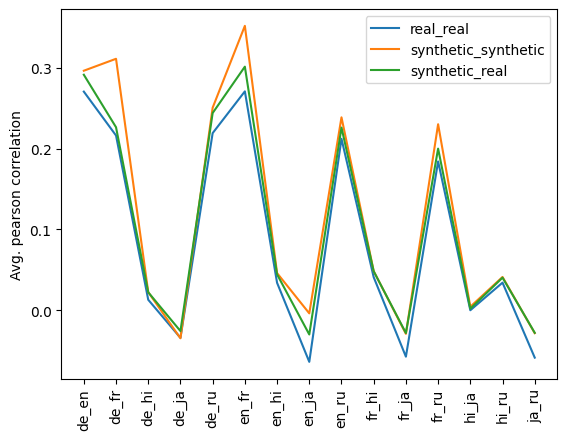

In [14]:
import os 
fig, ax = plt.subplots()

ax.plot(plotting_data.index, plotting_data['real_real'], label='real_real')
ax.plot(plotting_data.index, plotting_data['synthetic_synthetic'], label='synthetic_synthetic')
ax.plot(plotting_data.index, plotting_data['synthetic_real'], label='synthetic_real')
ax.set_xticklabels(plotting_data.index, rotation=90)
ax.set_ylabel('Avg. pearson correlation')
plt.legend()
img_save_path = f'../visuals/{data_source}/{model_name}/'
os.makedirs(img_save_path, exist_ok=True)
plt.savefig(f'../visuals/{data_source}/{model_name}/pearson_correlation.jpg', dpi=300, bbox_inches='tight')

**Conclusion.** The fact that real-real always below synthetic-synthetic implies representations more centralized in synthetic space. 

##### Hypothesis 2: synthetic-real will be closer to english across all langs than their own.

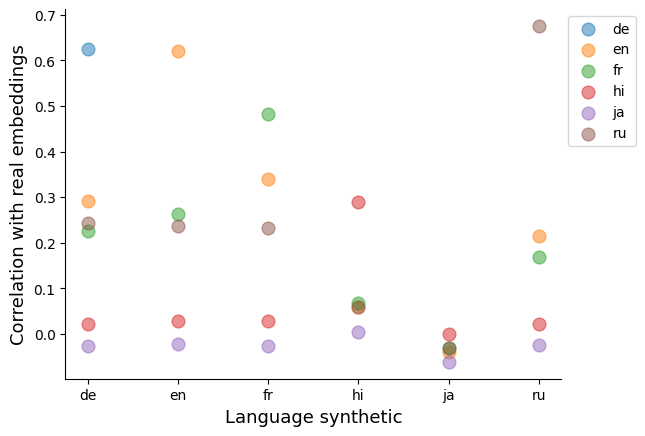

In [15]:
sr = df[df['setting'] == 'synthetic_real']

sr_pivot = sr.pivot(index='lang1', columns='lang2', values='pearson')


cols = sr_pivot.columns

fig, ax = plt.subplots()
for col in cols:
    sr_pivot[col] 
    ax.scatter(sr_pivot.index, sr_pivot[col], label=col, alpha=0.5, s=85)

ax.spines[['right','top']].set_visible(False)
ax.set_xlabel('Language synthetic', fontsize=13)
ax.set_ylabel("Correlation with real embeddings", fontsize=13)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.savefig(f'../visuals/{data_source}/{model_name}/synthetic_real_correlation_by_lang.jpg', dpi=300, bbox_inches='tight')


**Normalize the scores by the real-real similarity.** It's feasible, that the languages are not similar. Surprise. So we should adjust by there baseline similarity in the real-real case. 

TODO: consider if we should use the real Wikipedia embeddings to get an estimate of this. 


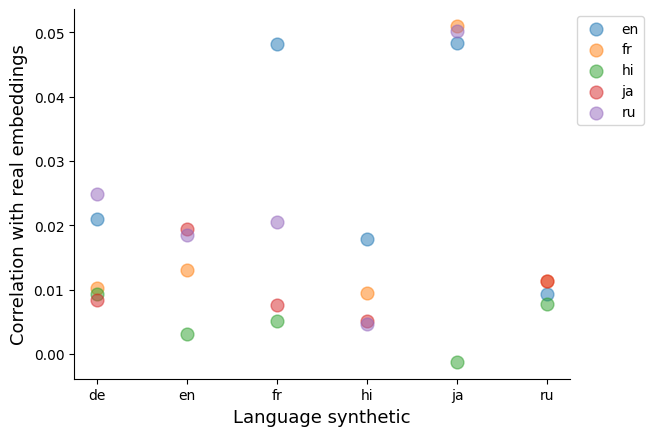

In [16]:
sr = df[df['setting'] == 'synthetic_real']
rr = df[df['setting'] == 'real_real']

sr_m = sr.merge(rr, on=['lang1', 'lang2'], suffixes=('_sr', '_rr'))
sr_m['diff'] = sr_m['pearson_sr'] - sr_m['pearson_rr']

sr_m_pivot = sr_m.pivot(index='lang1', columns='lang2', values='diff')


cols = sr_m_pivot.columns

fig, ax = plt.subplots()
for col in cols:
    sr_pivot[col] 
    ax.scatter(sr_m_pivot.index, sr_m_pivot[col], label=col, alpha=0.5, s=85)

ax.spines[['right','top']].set_visible(False)
ax.set_xlabel('Language synthetic', fontsize=13)
ax.set_ylabel("Correlation with real embeddings", fontsize=13)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.savefig(f'../visuals/{data_source}/{model_name}/synthetic_real_correlation_by_lang_diffed.jpg', dpi=300, bbox_inches='tight')


##### Hypothesis 3: There are structural patterns in terms of how languages differ.

NOTE: THIS IS NORTHERUALEX SPECIFIC

- Compare similarity across different semantic categories. 

In [ ]:
# only run for the NorthErualex_concepts data
cluster_path = '../data/NorthErualex_concepts/semantic_domain_to_word_forms.csv'

cluster_df = pd.read_csv(cluster_path)

lid_lid_mapping = {
    'ekk': 'et',
    'hin': 'hi',
    'rus': 'ru',
    'eng': 'en',
    'fra': 'fr',
    'jpn': 'ja',
    'deu': 'de'
}

cluster_df['language_id'] = cluster_df['language_id'].map(lid_lid_mapping)

In [ ]:
data_source = 'NorthErualex_concepts' # concreteness, NorthErualex_concepts
data_dir = f'../data/{data_source}/similarity/'
settings = ['synthetic_synthetic', 'real_real', 'synthetic_real']
langs = ['en','fr','de','ja', 'ru','et','hi']
model_name = 'Meta-Llama-3-1-8B-Instruct-nwxcg' # 'Meta-Llama-3-1-8B-Instruct-nwxcg', 'Meta-Llama-3-1-70B-Instruct-htzs'
pearsons_2 = []

for setting in settings:
    for lang1 in langs:
        for lang2 in langs: 
            if (lang1 == lang2) & (setting != 'synthetic_real'):
                continue
            
            data_path = f'{data_dir}{model_name}/{setting}/{lang1}_{lang2}.csv'
            try: 
                df = pd.read_csv(data_path)
                cluster_df_temp = cluster_df[cluster_df['language_id'] == lang1]
                df = df.merge(cluster_df, left_on='src_word', right_on='word_form')
                # pearson correlation btwn sim and tr_sim
                gps = df.groupby('semantic_domain')
                for name, gp in gps:
                    pearson = gp['sim'].corr(df['tr_sim'], method='pearson')
                    pearsons_2.append({
                        'lang1': lang1,
                        'lang2': lang2,
                        'setting': setting,
                        'pearson': pearson,
                        'semantic_domain': name,
                    })
            except Exception as e:
                print('no data for ', data_path)
                print(e)

no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_synthetic/en_fr.csv
name 'cluster_df' is not defined
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_synthetic/en_de.csv
name 'cluster_df' is not defined
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_synthetic/en_ja.csv
name 'cluster_df' is not defined
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_synthetic/en_ru.csv
name 'cluster_df' is not defined
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_synthetic/en_et.csv
name 'cluster_df' is not defined
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_synthetic/en_hi.csv
name 'cluster_df' is not defined
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-8B-Instruct-nwxcg/synthetic_syn

In [25]:
df2 = pd.DataFrame(pearsons_2)

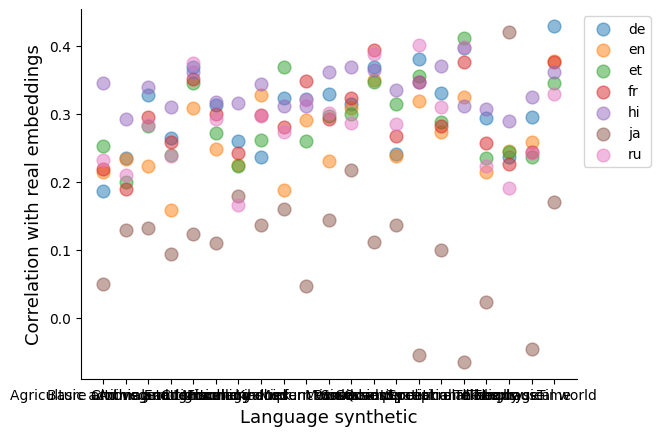

In [ ]:
sr = df2[df2['setting'] == 'synthetic_real']

sr = sr.groupby(['lang1', 'semantic_domain'])['pearson'].mean().reset_index()

sr_pivot = sr.pivot(index='semantic_domain', columns='lang1', values='pearson')


cols = sr_pivot.columns

fig, ax = plt.subplots()
for col in cols:
    sr_pivot[col] 
    ax.scatter(sr_pivot.index, sr_pivot[col], label=col, alpha=0.5, s=85)

ax.spines[['right','top']].set_visible(False)
ax.set_xlabel('Language synthetic', fontsize=13)
ax.set_ylabel("Correlation with real embeddings", fontsize=13)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
# plt.savefig(f'../visuals/north_euralex_concepts/{model_name}/synthetic_real_correlation_by_lang.jpg', dpi=300, bbox_inches='tight')


### Hypothesis 4: We will notice more similarity with English with abstract words

* load in the concreteness scores for the words
* for each language measure the similarity to all languages (similar to above)
* group by the concreteness buckets 

In [2]:
concreteness_path = '../data/concreteness/conc_translated.csv'
concreteness_df = pd.read_csv(concreteness_path)

In [8]:
data_source = 'concreteness' # concreteness, NorthErualex_concepts
data_dir = f'../data/{data_source}/similarity/'
settings = ['synthetic_synthetic', 'real_real', 'synthetic_real']
langs = ['en','fr','de','ja', 'ru','et','hi']
model_name = 'Meta-Llama-3-1-70B-Instruct-htzs' # 'Meta-Llama-3-1-8B-Instruct-nwxcg', 'Meta-Llama-3-1-70B-Instruct-htzs'
pearsons_2 = []

for setting in settings:
    for lang1 in langs:
        for lang2 in langs: 
            if (lang1 == lang2) & (setting != 'synthetic_real'):
                continue
            
            data_path = f'{data_dir}{model_name}/{setting}/{lang1}_{lang2}.csv'
            try: 
                df = pd.read_csv(data_path)
                # apply cleaning 
                df = filter_df(df)
                cluster_df_temp = concreteness_df[concreteness_df['lang'] == lang1]
                cluster_df_temp = cluster_df_temp[['translation', 'concreteness_tile']]
                df = df.merge(concreteness_df, left_on='src_word', right_on='translation')
                # pearson correlation btwn sim and tr_sim
                gps = df.groupby('concreteness_tile')
                for name, gp in gps:
                    pearson = gp['sim'].corr(df['tr_sim'], method='pearson')
                    pearsons_2.append({
                        'lang1': lang1,
                        'lang2': lang2,
                        'setting': setting,
                        'pearson': pearson,
                        'concreteness': name,
                    })
            except Exception as e:
                print('no data for ', data_path)
                print(e)    

no data for  ../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/en_de.csv
[Errno 2] No such file or directory: '../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/en_de.csv'
no data for  ../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/en_et.csv
[Errno 2] No such file or directory: '../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/en_et.csv'
no data for  ../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/fr_de.csv
[Errno 2] No such file or directory: '../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/fr_de.csv'
no data for  ../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/fr_et.csv
[Errno 2] No such file or directory: '../data/concreteness/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/fr_et.csv'
no data for  ../data/concretenes

In [18]:
data

,lang1,lang2,setting,pearson,concreteness
0,en,fr,synthetic_synthetic,0.439852,1
1,en,fr,synthetic_synthetic,0.414145,2
2,en,fr,synthetic_synthetic,0.440725,3
3,en,fr,synthetic_synthetic,0.443903,4
4,en,fr,synthetic_synthetic,0.418605,5
...,...,...,...,...,...
805,hi,hi,synthetic_real,0.373414,6
806,hi,hi,synthetic_real,0.352781,7
807,hi,hi,synthetic_real,0.431959,8
808,hi,hi,synthetic_real,0.396120,9


<Axes: xlabel='concreteness'>

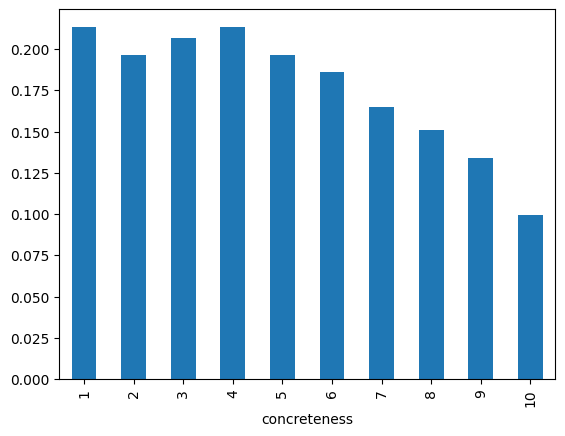

In [21]:
df = pd.DataFrame(pearsons_2)
df = df[df['setting'] == 'synthetic_real']

df.groupby('concreteness')['pearson'].mean().plot(kind='bar')

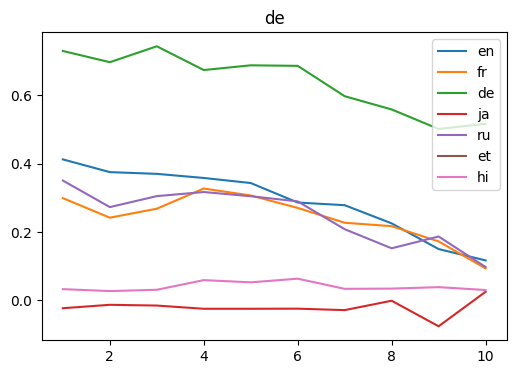

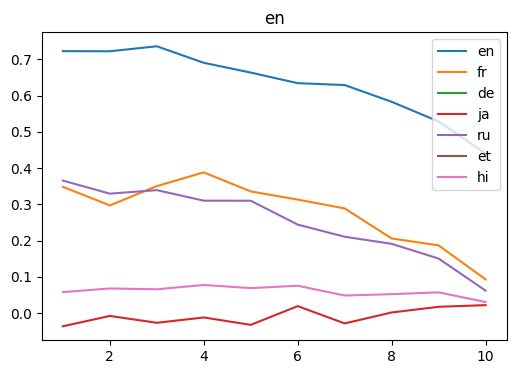

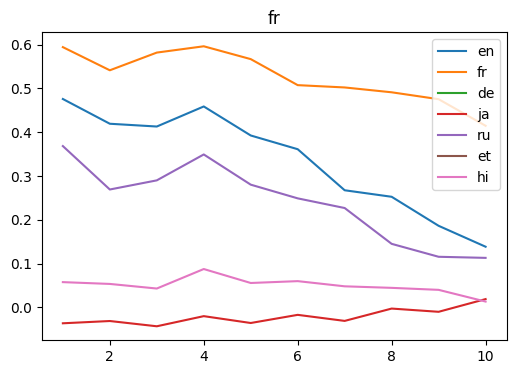

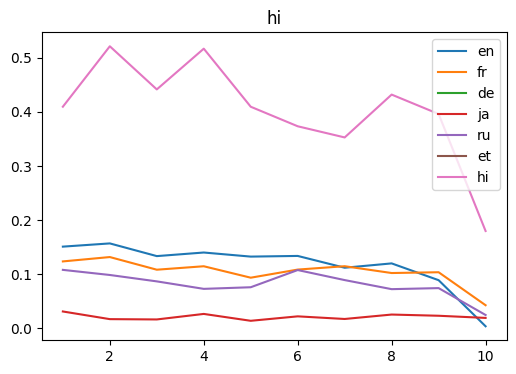

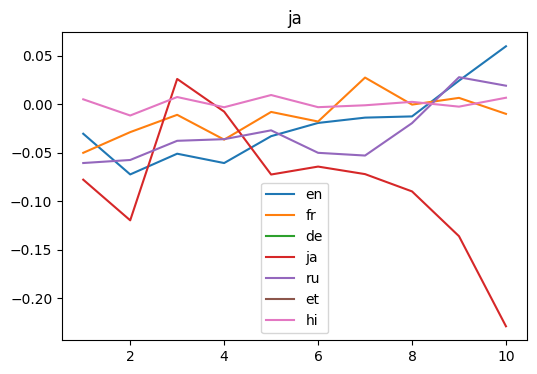

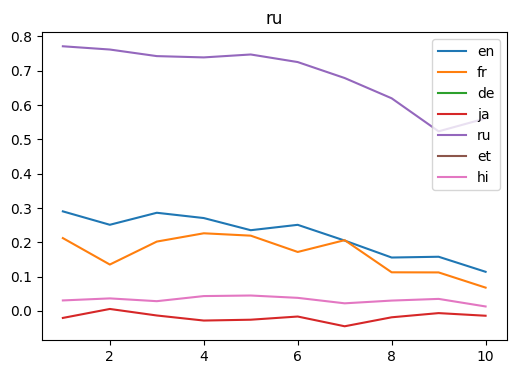

In [25]:
# lang1 is the synthetic 
gps = df.groupby('lang1')

for name, gp in gps: 
    fig, ax = plt.subplots(figsize=(6,4))
    # avg corr 
    avg = gp.groupby(['concreteness', 'lang2'])['pearson'].mean().reset_index()

    for lang2 in langs:
        ax.plot(avg[avg['lang2'] == lang2]['concreteness'], avg[avg['lang2'] == lang2]['pearson'], label=lang2)
    
    plt.legend()
    plt.title(name)
    plt.show()